In [138]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pandas.plotting import lag_plot

[*********************100%***********************]  1 of 1 completed


                            OLS Regression Results                            
Dep. Variable:      1 Period % Change   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                   0.02476
Date:                Mon, 16 Jun 2025   Prob (F-statistic):              0.875
Time:                        14:29:03   Log-Likelihood:                 466.89
No. Observations:                 277   AIC:                            -929.8
Df Residuals:                     275   BIC:                            -922.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.003      1.021      0.3

Price,Adj Close,Close,High,Low,Open,Volume,Close + 1,1 Period % Change,High_2prev,Bull_FVG,Bull_FVG_Val,Low_2prev,Bear_FVG,Bear_FVG_Val,Both_FVG,Predictions,Residuals
11,133.800003,133.800003,137.210007,130.160004,135.500000,365400,136.630005,0.021151,141.500000,0,-0.000000,138.600006,1,-0.010389,-0.010389,0.002663,-0.018488
16,126.160004,126.160004,131.000000,125.099998,130.779999,303100,126.029999,-0.001030,136.130005,0,-0.000000,132.199997,1,-0.009512,-0.009512,0.002672,0.003702
17,126.029999,126.029999,127.400002,125.010002,126.500000,132000,124.010002,-0.016028,133.970001,0,-0.000000,129.139999,1,-0.013806,-0.013806,0.002630,0.018658
20,127.330002,127.330002,130.580002,126.290001,127.279999,113400,120.000000,-0.057567,126.000000,1,0.002278,123.000000,0,0.000000,0.002278,0.002786,0.060353
22,120.099998,120.099998,120.775002,118.544998,119.800003,188400,128.699997,0.071607,130.580002,0,-0.000000,126.290001,1,-0.045920,-0.045920,0.002319,-0.069288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945,486.420013,486.420013,487.000000,433.000000,436.924988,3054900,494.130005,0.015850,390.410004,1,0.087558,371.309998,0,0.000000,0.087558,0.003612,-0.012238
946,494.130005,494.130005,504.309998,475.529999,480.660004,1868900,490.549988,-0.007245,406.000000,1,0.140712,390.000000,0,0.000000,0.140712,0.004128,0.011373
952,531.460022,531.460022,536.870972,514.804993,519.359985,823900,540.679993,0.017348,513.869995,1,0.001759,500.260010,0,0.000000,0.001759,0.002781,-0.014567
970,497.929993,497.929993,509.480011,485.529999,509.480011,1006900,486.019989,-0.023919,531.872986,0,-0.000000,518.000000,1,-0.017111,-0.017111,0.002598,0.026517


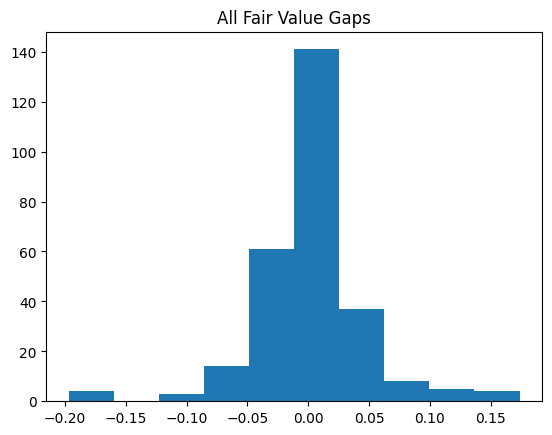

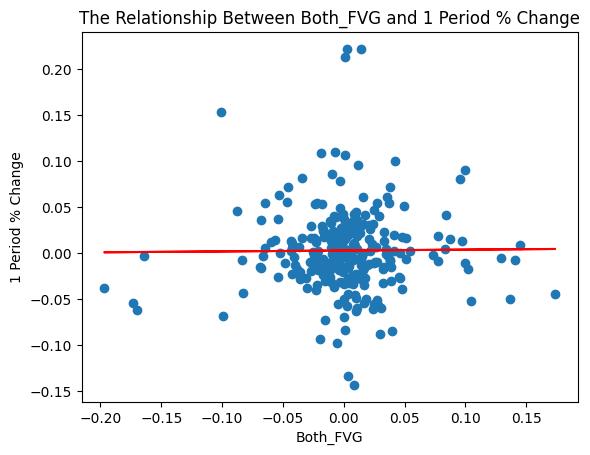

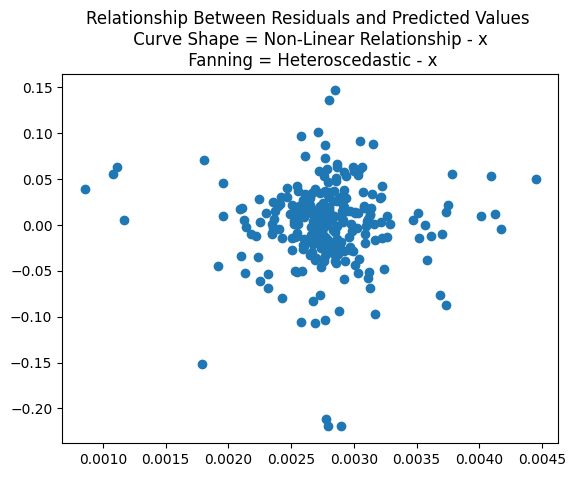

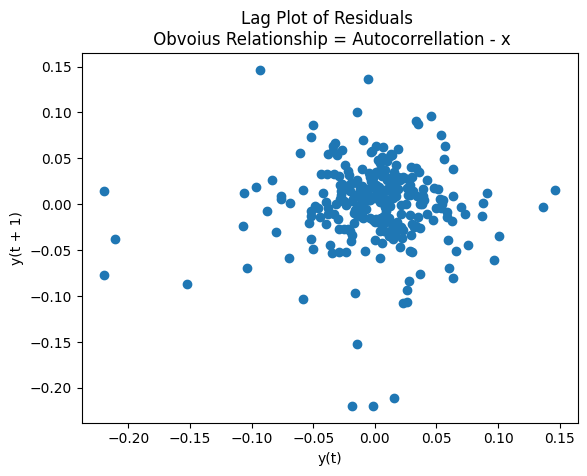

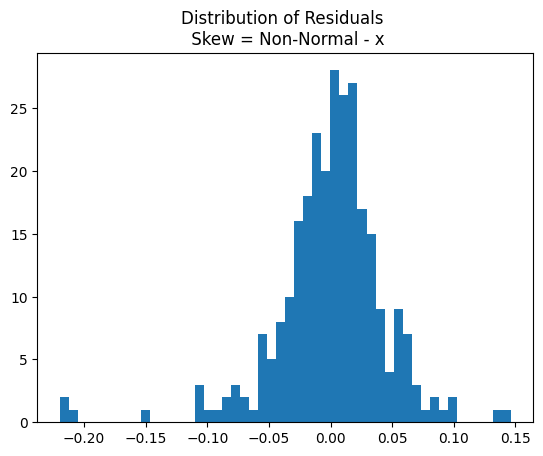

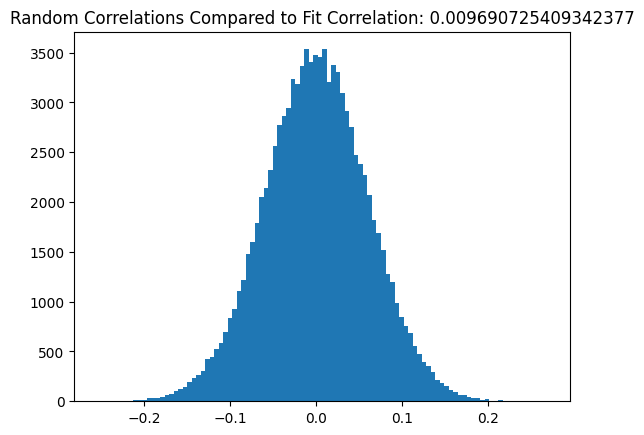

In [ ]:
TICKER = 'DUOL'
INTERVAL='1d'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

SHIFT = 1
STRATEGY = 'Both_FVG'

# what subsetion of that data are you interested in
LOOKBACK = 10000

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, auto_adjust=False, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

# define the target variable (also called dependent variable, or y)
def add_target(df, shift=SHIFT):

    # what is the close price SHIFT days from now?
    df[f'Close + {shift}'] = df['Close'].shift(-shift)

    # what is the change in close price SHIFT days from now?
    df[f'{shift} Period % Change'] = (df[f'Close + {shift}'] - df['Close']) / df['Close']

    return df

def bull_fvg(df):

    df['High_2prev'] = df['High'].shift(2)
    df['Bull_FVG'] = (df['Low'] > df['High_2prev']).astype(int)
    df['Bull_FVG_Val'] = (df['Low'] - df['High_2prev']) * df['Bull_FVG'] / df['Close']

    return df

def bear_fvg(df):

    df['Low_2prev'] = df['Low'].shift(2)
    df['Bear_FVG'] = (df['High'] < df['Low_2prev']).astype(int)
    df['Bear_FVG_Val'] = (df['High'] - df['Low_2prev']) * df['Bear_FVG'] / df['Close']

    return df

def prepare_dataframe_for_regression(df):
    df = df[(df['Bull_FVG'] == 1) | (df['Bear_FVG'] == 1)].copy()
    df['Both_FVG'] = df['Bear_FVG_Val'] + df['Bull_FVG_Val']

    plt.figure()
    plt.hist(df['Both_FVG'])
    plt.title('All Fair Value Gaps')

    return df

def generate_regression_output(df, features=f'{STRATEGY}', target=f'{SHIFT} Period % Change'):
    subset = df[[features, target]].dropna()

    X = subset[features]
    y = subset[target]

    X_with_const = sm.add_constant(X)
    model = sm.OLS(y, X_with_const).fit()

    intercept = model.params['const']
    coefficient = model.params[features]
    r2 = model.rsquared
    p_value = model.pvalues[features]
    n_obs = len(subset)

    y_pred = model.predict(X_with_const)

    # Console summary
    print(model.summary())
    print(f"\n[Regression Summary]")
    print(f"Observations: {n_obs}")
    print(f"Coefficient: {coefficient:.6f}")
    print(f"Intercept: {intercept:.6f}")
    print(f"R²: {r2:.6f}")
    print(f"P-Value: {p_value:.6f}")

    # Plot
    plt.figure()
    plt.title(f'The Relationship Between {features} and {target}')
    plt.plot(X, y_pred, color='red', label=f'y = {coefficient:.2f}x + {intercept:.2f}')
    plt.scatter(X, y, alpha=0.6)
    plt.xlabel(f"{features}")
    plt.ylabel(f"{target}")
    plt.legend()
    plt.grid(True)

    return df, intercept, coefficient

def validate_regression_output(df, coef, intercept):

    # information necessary
    df['Predictions'] = coef * df[f'{STRATEGY}'] + intercept
    df['Residuals'] = df['Predictions'] - df[f'{SHIFT} Period % Change']

    # plot for linearity/homoscedasticity
    plt.figure()
    plt.scatter(df['Predictions'], df['Residuals'])
    plt.title('Relationship Between Residuals and Predicted Values \n ' \
        'Curve Shape = Non-Linear Relationship - x \n ' \
        'Fanning = Heteroscedastic - x')
    
    # plot for autocorrelations
    plt.figure()
    lag_plot(df['Residuals'].dropna())
    plt.title('Lag Plot of Residuals \n Obvoius Relationship = Autocorrellation - x')

    # plot for normality
    plt.figure()
    plt.hist(df['Residuals'], bins=50)
    plt.title('Distribution of Residuals \n Skew = Non-Normal - x')

    return df

def assess_regression_output(df, coef, features=f'{STRATEGY}', target=f'{SHIFT} Period % Change', n=100000):
    subset = df[[features, target]].dropna()
    X = subset[features]
    y = subset[target]

    real_r = np.corrcoef(X, y)[0, 1]
    correlations = []

    for _ in range(n):
        shuffled_y = np.random.permutation(y)
        r = np.corrcoef(X, shuffled_y)[0, 1]
        correlations.append(r)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.hist(correlations, bins=100, alpha=0.7, color='skyblue', label='Shuffled Correlations')
    plt.axvline(real_r, color='red', linestyle='--', label=f'Real Correlation = {real_r:.4f}')
    plt.title('Null Distribution of Correlation (Shuffled Targets)')
    plt.xlabel('Correlation Coefficient (r)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)

    return df

def main():
    df = get_data()
    df = add_target(df)
    df = bull_fvg(df)
    df = bear_fvg(df)
    df = prepare_dataframe_for_regression(df)
    df, fit_intercept, fit_coefficient = generate_regression_output(df)
    df = validate_regression_output(df, coef=fit_coefficient, intercept=fit_intercept)
    df = assess_regression_output(df, coef=fit_coefficient)

    return df

df = main()
df